In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import datetime
import seaborn as sns
from scipy import stats

In [2]:
def scale(dataset,col_name, output_array=False):
    """Standard Z score scaler"""
    array = dataset[col_name].to_numpy()
    mean = np.mean(array)
    std = np.std(array)
    scaled = (array-mean)/std
    if output_array:
        return scaled
    else:
        return scaled, mean, std 

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, variable_num = 0,  dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[variable_num].shift(-i))
        if i == 0:
            names.append('var1(t)')
        else:
            names.append('var%d(t+%d)' % (1, i))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg, names

In [4]:
def random_date(array, lockdown=False):
    """ Choose a random date within lockdown or out of lockdown."""
    if lockdown:
        return np.random.choice(array[(array > pd.to_datetime('2020-03-24')) & (array < pd.to_datetime('2020-06-23')) ])
    else:
        #ensure a years worth of hourly data is available for training.
        array = pd.to_datetime(array[(24*365):])
        
        # 2020-01-01 ensures only non-lockdown entries will be considered
        return np.random.choice(array[array < pd.to_datetime('2020-01-01')])

In [5]:
def split_by_date( dataset , reframed_data, date, n_hours ,days_prior=60):
    
    """ Split reframed data by specific date, days refers to the number 
    of days after the specified date the test set will contain.
    days prior refers to the number of days used to train the model """
    
    #get values from reframed data
    values = reframed_data.values
    
    #convert string into datetime
    date = pd.to_datetime(date)
    
    #create new dataframe
    df = dataset.reset_index().rename(columns = {'index':'date'})
    
    #ensure dates are in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    #find index for date
    date1_index = df.index[df['date'] == date ][0]
    
    #set train values to be all data upto given date 
    train = values[ date1_index - n_hours - (24*days_prior) : date1_index - n_hours, :]

    #get index of second date is 1 month into future
    date2_index = date1_index + (30 * 24)

    #test set two months after specified date
    test = values[ ( date1_index - n_hours ) : (date2_index - n_hours)  + 1 , :]
    
    #get specific dates for test period
    dates = df.date.to_numpy()
    specific_dates = dates[ date1_index  : date2_index+1  ]

    
    return train , test, specific_dates

In [6]:
def reshape(data, n_features, n_hours, hours_after):
    """ Reshape puts data in apprpriate format for LSTM usage
    [samples, timesteps, features] """
    n_obs = n_hours * n_features

    #split according to lag columns and output
    data_X, data_y = data[:, :n_obs], data[:, -hours_after:]
         
    # reshape input to be 3D [samples, timesteps, features]
    data_X_r = data_X.reshape((data_X.shape[0], n_hours , n_features))

    return data_X, data_y , data_X_r 

In [7]:
def inverse_scale(array,mean,std):
    """ Inversion of Standard scaler """
    inverse = (array*std) + mean 
    return inverse

In [8]:
def LSTM_model(cells,dropout,n_hours,n_hours_out, train_X_r):
    # design network
    model = Sequential()
    model.add(LSTM(cells, activation = 'relu',dropout=dropout,input_shape=(train_X_r.shape[1], train_X_r.shape[2])))
    model.add(Dense(n_hours, activation = 'relu'))
    model.add(Dense(n_hours_out))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return model

In [9]:
def hour_predictor(test_r, model ,index , timesteps, n_hours, n_features):
    """ Rolling one hour prediction: uses previous 
    1 hour predictions to predict 1 hour ahead """
    
    #starting sequence used to get first prediction. 
    start = test_r[index].reshape(1,n_hours,n_features)
    
    #empty array to store results 
    results = []
    
    #get first prediction
    result = model.predict(start)[0][0]
    
    #record it 
    results.append(result)
    
    for i in range (1,timesteps):

        #shift window one time step
        start = np.delete(start[0],0,0)
        next_ts = test_r[index+i][2]
        start = np.append(start,next_ts).reshape(1,n_hours,n_features)

        #add prediction
        start[0][n_hours-1][0] = result

        #make new prediction
        result = model.predict(start)[0][0]

        results.append(result)
        
    return np.array(results)

In [10]:
def load_data (site):
    # load dataset

    dataset = pd.read_csv('./'+ site + '_combined.csv', header=0, index_col=0)

    #get all dates
    all_dates = pd.to_datetime(dataset.index.to_numpy())

    # scale NO2 keep mean and std for inverse scaling
    no2, mean, std, = scale(dataset,'NO2',output_array=False)
    dataset['NO2'] = no2

    dataset = dataset[['NO2']]
    
    return dataset, mean, std
    

In [11]:
# paramter ranges
BATCH_SIZE = 128
CELLS = 24
DROPOUT= 0.
EPOCHS = 100
TRAIN_SIZE = 365
TIMESTEPS = [1,3,5,12] # for rolling prediction
DATES = ['2020-03-23','2020-01-23']
SITES = ['MCC', 'sharston']
    
results = []

In [12]:
#-----------UPDATE PREDICTOR-----------
def update_predictor (site,timesteps,period,reps,save=True):
    #specify bounds of lag and prediction
    
    dataset, mean, std = load_data(site)
    
    hours_before = 24
    hours_after = timesteps

    days_before = 1
    days_after = 1

    # # specify the number of lag hours
    n_hours = hours_before * days_before # lag hours for each feature (t-x)
    n_features = len(dataset.columns) # number of features 
    n_hours_out = hours_after * days_after # lenghth of output forecast (<1 == <t+1)


    #convert values
    values = dataset.values.astype('float32') 

    # frame as supervised learning
    reframed, names = series_to_supervised(values, n_hours, n_hours_out )


    train , test,  dates  = split_by_date(dataset, reframed, period, n_hours, TRAIN_SIZE)

    #print(train.shape, test.shape, dates.shape)

    train_X, train_y , train_X_r = reshape(train,n_features,n_hours,hours_after)
    test_X, test_y , test_X_r = reshape(test,n_features,n_hours,hours_after)

    #print( train_X_r.shape, test_X_r.shape)

    for rep in range (reps):

        model = LSTM_model(CELLS,DROPOUT,n_hours,n_hours_out,train_X_r)

        # fit network
        history = model.fit(train_X_r, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = 0.2 , verbose=0, shuffle=False)

        # get scaled prediction and observed values to calculate RMSE
        predicted = model.predict(test_X_r)[::n_hours_out]
        observed = test_y[::n_hours_out]

        # rescale for plotting
        predicted_rescaled = inverse_scale(predicted.flatten(), mean, std)[:dates.shape[0]]
        observed_rescaled = inverse_scale(observed.flatten(), mean, std)[:dates.shape[0]]

        #calculate RMSE
        RMSE = mean_squared_error(observed_rescaled, predicted_rescaled, squared = False)

        #calculate MAPE
        MAPE =  mean_absolute_percentage_error(observed_rescaled, predicted_rescaled)

        #correlation
        corr, p = pearsonr(observed_rescaled, predicted_rescaled)

    #     #calculate mean RMSE for each timestep 
    #     lag_scores = np.array([mean_squared_error(observed_update[i],predicted_update[i], squared=False ) for i in range(observed_update.shape[0])])
    #     lag_scores = np.mean(lag_scores.reshape(int(observed_update.shape[0]/TIMESTEPS),TIMESTEPS),axis=0)

    #     print (f"Rolling Predictor: Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, TIMESTEP:{TIMESTEPS}, RMSE:{total_score}, Lag Scores {lag_scores}")
        
        if save:
            print (RMSE,MAPE,corr,p)
            results.append(['Update',site,period,timesteps,RMSE, MAPE,corr,p])
        
    return observed_rescaled, predicted_rescaled, dates 

In [13]:
# ----- ROLLING 1 HOUR PREDICTOR---------
def rolling_predictor (site,timesteps,period,reps,save=True):
    
    dataset, mean, std = load_data(site)
    
    #specify bounds of lag and prediction
    hours_before = 24
    hours_after = 1

    days_before = 1
    days_after = 1

    # # specify the number of lag hours
    n_hours = hours_before * days_before # lag hours for each feature (t-x)
    n_features = len(dataset.columns) # number of features 
    n_hours_out = hours_after * days_after # lenghth of output forecast (<1 == <t+1)

    #convert values
    values = dataset.values.astype('float32') 

    # frame as supervised learning
    reframed, names = series_to_supervised(values, n_hours, n_hours_out )

    
    train , test,  dates  = split_by_date(dataset, reframed, period, n_hours, TRAIN_SIZE)

    train_X, train_y , train_X_r = reshape(train,n_features,n_hours,hours_after)
    test_X, test_y , test_X_r = reshape(test,n_features,n_hours,hours_after)

    for rep in range (reps):

        model = LSTM_model(CELLS,DROPOUT,n_hours,n_hours_out,train_X_r)

        # fit network
        history = model.fit(train_X_r, train_y, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_split = 0.2 , verbose=0, shuffle=False)

        #timesteps = how far ahead the rolling 1 hour predictor will forcast. 
        # array of indexes  
        indexes = np.arange(0,test_X_r.shape[0] - timesteps , timesteps)

        # use rolling hour predictor to predict x timesteps ahead at each index within the array to get 
        # contiguous predictions over a longer timeframe.
        predicted = np.array([hour_predictor(test_X_r, model, i, timesteps,n_hours, n_features) for i in indexes]).flatten()

        #invert scale and reshape for evaluation
        predicted_rescaled = inverse_scale( predicted.reshape(len(predicted),1), mean, std )

        #invert scale observed values, trim observed values so that predicted and observed have equal sizes and shape
        observed_rescaled = inverse_scale(test_y.flatten()[:predicted.shape[0]],mean,std).reshape(predicted.shape[0],1)

        #calculate RMSE
        RMSE = mean_squared_error(observed_rescaled.flatten(), predicted_rescaled.flatten(), squared = False)

        #calculate MAPE
        MAPE =  mean_absolute_percentage_error(observed_rescaled.flatten(), predicted_rescaled.flatten())

        #correlation
        corr, p = pearsonr(observed_rescaled.flatten(), predicted_rescaled.flatten())

    #     #calculate mean RMSE for each timestep 
    #     lag_scores = np.array([mean_squared_error(observed[i],predicted[i], squared=False ) for i in range(observed.shape[0])])
    #     lag_scores = np.mean(lag_scores.reshape(int(observed.shape[0]/TIMESTEPS),TIMESTEPS),axis=0)

    #     print (f"Rolling Predictor: Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, TIMESTEP:{TIMESTEPS}, RMSE:{total_score}, Lag Scores {lag_scores}")

        
        if save:
            print (RMSE,MAPE,corr,p)
            results.append(['Running',site,period,timesteps,RMSE, MAPE,corr,p])
    
    return observed_rescaled.flatten(), predicted_rescaled.flatten(), dates
        

In [14]:
# for s in SITES:
#     for t in TIMESTEPS:
#         for d in DATES:
#             observed_rescaled, predicted_rescaled, dates = update_predictor(s,t,d,5)
#             print ('update', s,t,d, 'DONE')
#             observed_rescaled, predicted_rescaled, dates = rolling_predictor(s,t,d,5)
#             print ('rolling', s,t,d, 'DONE')            

In [15]:
#pd.DataFrame(results, columns = ['Type','Site','Date','Forecast','RMSE','MAPE','Correlation','P-value']).to_csv('./extending_forecasts.csv')

In [17]:
#MMC LD
observed_rescaled, predicted_rescaled, dates = update_predictor('MCC',1,'2020-03-23',1,save=False)
observed_rescaled3, predicted_rescaled3, dates3 = update_predictor('MCC',3,'2020-03-23',1,save=False)
observed_rescaled5, predicted_rescaled5, dates5 = update_predictor('MCC',5,'2020-03-23',1,save=False)
observed_rescaled12, predicted_rescaled12, dates12 = update_predictor('MCC',12,'2020-03-23',1,save=False)

observed_rescaledr, predicted_rescaledr, datesr = rolling_predictor('MCC',1,'2020-03-23',1,save=False)
observed_rescaledr3, predicted_rescaledr3, datesr3 = rolling_predictor('MCC',3,'2020-03-23',1,save=False)
observed_rescaledr5, predicted_rescaledr5, datesr5 = rolling_predictor('MCC',5,'2020-03-23',1,save=False)
observed_rescaledr12, predicted_rescaledr12, datesr12 = rolling_predictor('MCC',12,'2020-03-23',1,save=False)

#MMC NonLD
observed_rescaled_nld, predicted_rescaled_nld, dates_nld = update_predictor('MCC',1,'2020-01-23',1,save=False)
observed_rescaled3_nld, predicted_rescaled3_nld, dates3_nld = update_predictor('MCC',3,'2020-01-23',1,save=False)
observed_rescaled5_nld, predicted_rescaled5_nld, dates5_nld = update_predictor('MCC',5,'2020-01-23',1,save=False)
observed_rescaled12_nld, predicted_rescaled12_nld, dates12_nld = update_predictor('MCC',12,'2020-01-23',1,save=False)

observed_rescaledr_nld, predicted_rescaledr_nld, datesr_nld = rolling_predictor('MCC',1,'2020-01-23',1,save=False)
observed_rescaledr3_nld, predicted_rescaledr3_nld, datesr3_nld = rolling_predictor('MCC',3,'2020-01-23',1,save=False)
observed_rescaledr5_nld, predicted_rescaledr5_nld, datesr5_nld = rolling_predictor('MCC',5,'2020-01-23',1,save=False)
observed_rescaledr12_nld, predicted_rescaledr12_nld, datesr12_nld = rolling_predictor('MCC',12,'2020-01-23',1,save=False)


In [19]:
#sharston LD
s_observed_rescaled, s_predicted_rescaled, s_dates = update_predictor('sharston',1,'2020-03-23',1,save=False)
s_observed_rescaled3, s_predicted_rescaled3, s_dates3 = update_predictor('sharston',3,'2020-03-23',1,save=False)
s_observed_rescaled5, s_predicted_rescaled5, s_dates5 = update_predictor('sharston',5,'2020-03-23',1,save=False)
s_observed_rescaled12, s_predicted_rescaled12, s_dates12 = update_predictor('sharston',12,'2020-03-23',1,save=False)

s_observed_rescaledr, s_predicted_rescaledr, s_datesr = rolling_predictor('sharston',1,'2020-03-23',1,save=False)
s_observed_rescaledr3, s_predicted_rescaledr3, s_datesr3 = rolling_predictor('sharston',3,'2020-03-23',1,save=False)
s_observed_rescaledr5, s_predicted_rescaledr5, s_datesr5 = rolling_predictor('sharston',5,'2020-03-23',1,save=False)
s_observed_rescaledr12, s_predicted_rescaledr12, s_datesr12 = rolling_predictor('sharston',12,'2020-03-23',1,save=False)

#sharston NonLD
s_observed_rescaled_nld, s_predicted_rescaled_nld, s_dates_nld = update_predictor('sharston',1,'2020-01-23',1,save=False)
s_observed_rescaled3_nld, s_predicted_rescaled3_nld, s_dates3_nld = update_predictor('sharston',3,'2020-01-23',1,save=False)
s_observed_rescaled5_nld, s_predicted_rescaled5_nld, s_dates5_nld = update_predictor('sharston',5,'2020-01-23',1,save=False)
s_observed_rescaled12_nld, s_predicted_rescaled12_nld, s_dates12_nld = update_predictor('sharston',12,'2020-01-23',1,save=False)

s_observed_rescaledr_nld, s_predicted_rescaledr_nld, s_datesr_nld = rolling_predictor('sharston',1,'2020-01-23',1,save=False)
s_observed_rescaledr3_nld, s_predicted_rescaledr3_nld, s_datesr3_nld = rolling_predictor('sharston',3,'2020-01-23',1,save=False)
s_observed_rescaledr5_nld, s_predicted_rescaledr5_nld, s_datesr5_nld = rolling_predictor('sharston',5,'2020-01-23',1,save=False)
s_observed_rescaledr12_nld, s_predicted_rescaledr12_nld, s_datesr12_nld = rolling_predictor('sharston',12,'2020-01-23',1,save=False)


In [36]:
legendsize=18
font_size=18

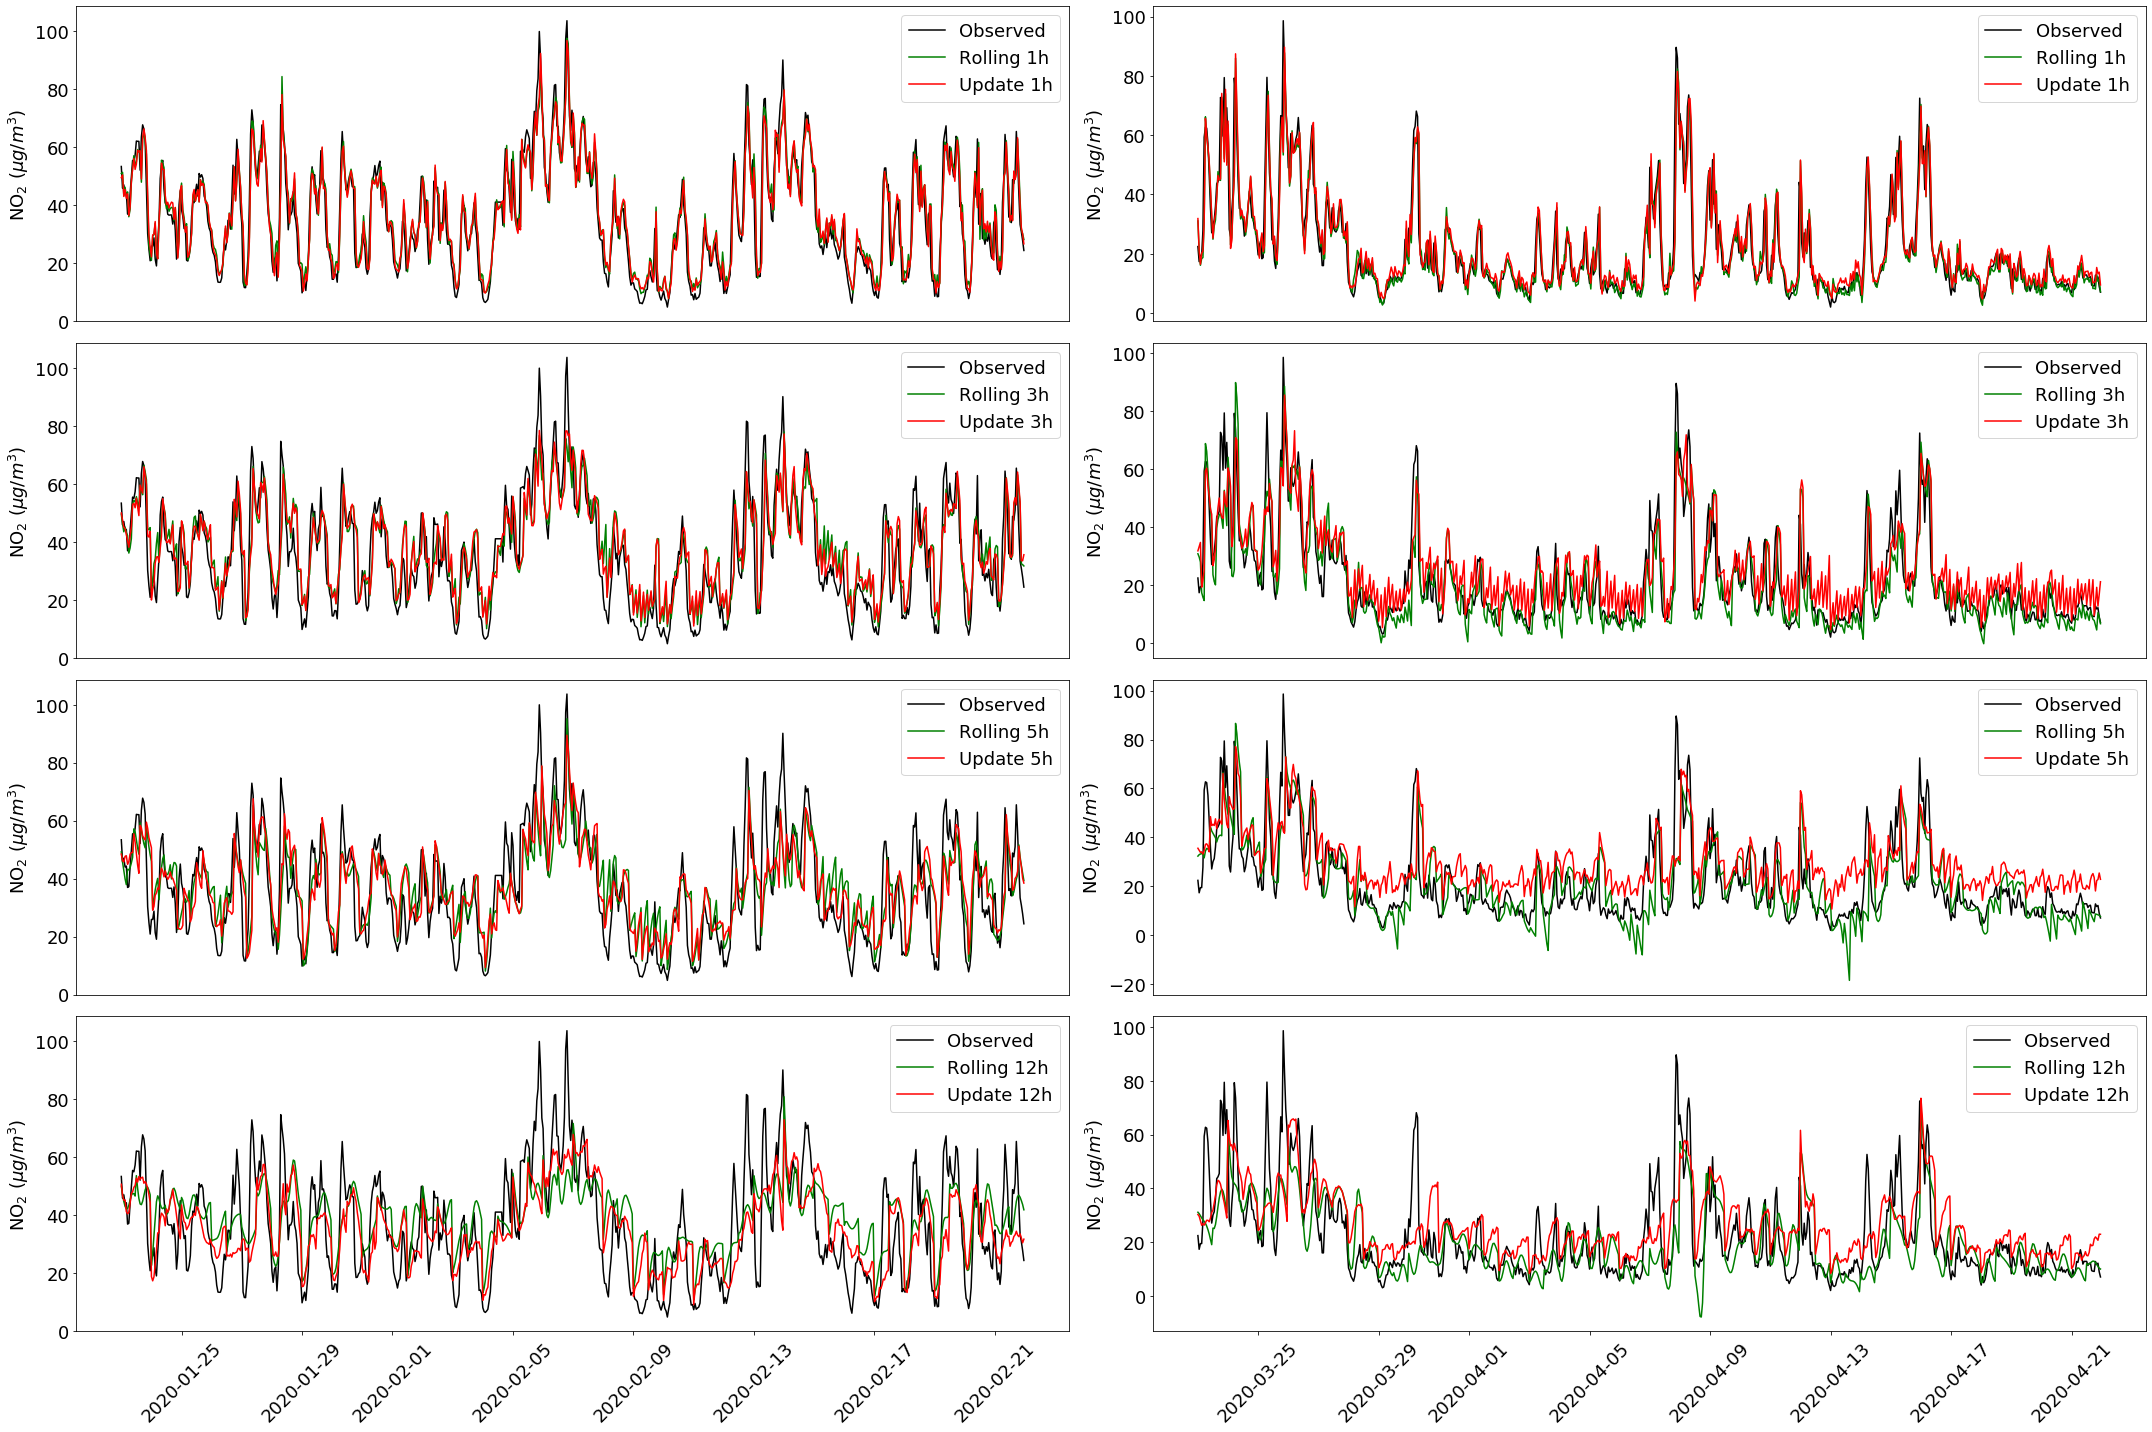

In [39]:
plt.figure(figsize=(30,20))
plt.subplot(4,2,1)
plt.plot(dates_nld[:24*30],observed_rescaled_nld[:24*30],color='k',label='Observed')
plt.plot(datesr_nld[:24*30],predicted_rescaledr_nld[:24*30],color='green',label='Rolling 1h')
plt.plot(dates_nld[:24*30],predicted_rescaled_nld[:24*30],color='r',label='Update 1h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,2)
plt.plot(dates[:24*30],observed_rescaled[:24*30],color='k',label='Observed')
plt.plot(datesr[:24*30],predicted_rescaledr[:24*30],color='green',label='Rolling 1h')
plt.plot(dates[:24*30],predicted_rescaled[:24*30],color='r',label='Update 1h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,3)
plt.plot(dates_nld[:24*30],observed_rescaled_nld[:24*30],color='k',label='Observed')
plt.plot(datesr_nld[:24*30],predicted_rescaledr3_nld[:24*30],color='green',label='Rolling 3h')
plt.plot(dates_nld[:24*30],predicted_rescaled3_nld[:24*30],color='r',label='Update 3h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,4)
plt.plot(dates[:24*30],observed_rescaled[:24*30],color='k',label='Observed')
plt.plot(datesr[:24*30],predicted_rescaledr3[:24*30],color='green',label='Rolling 3h')
plt.plot(dates[:24*30],predicted_rescaled3[:24*30],color='r',label='Update 3h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,5)
plt.plot(dates_nld[:24*30],observed_rescaled_nld[:24*30],color='k',label='Observed')
plt.plot(datesr_nld[:24*30],predicted_rescaledr5_nld[:24*30],color='green',label='Rolling 5h')
plt.plot(dates_nld[:24*30],predicted_rescaled5_nld[:24*30],color='r',label='Update 5h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,6)
plt.plot(dates[:24*30],observed_rescaled[:24*30],color='k',label='Observed')
plt.plot(datesr[:24*30],predicted_rescaledr5[:24*30],color='green',label='Rolling 5h')
plt.plot(dates[:24*30],predicted_rescaled5[:24*30],color='r',label='Update 5h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,7)
plt.plot(dates_nld[:24*30],observed_rescaled_nld[:24*30],color='k',label='Observed')
plt.plot(datesr_nld[:24*30],predicted_rescaledr12_nld[:24*30],color='green',label='Rolling 12h')
plt.plot(dates_nld[:24*30],predicted_rescaled12_nld[:24*30],color='r',label='Update 12h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.xticks(rotation=45)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,8)
plt.plot(dates[:24*30],observed_rescaled[:24*30],color='k',label='Observed')
plt.plot(datesr[:24*30],predicted_rescaledr12[:24*30],color='green',label='Rolling 12h')
plt.plot(dates[:24*30],predicted_rescaled12[:24*30],color='r',label='Update 12h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.xticks(rotation=45)
plt.legend(prop={'size':legendsize})
plt.tight_layout()
plt.savefig('./figures/piccadilly_ext_forecast.png')

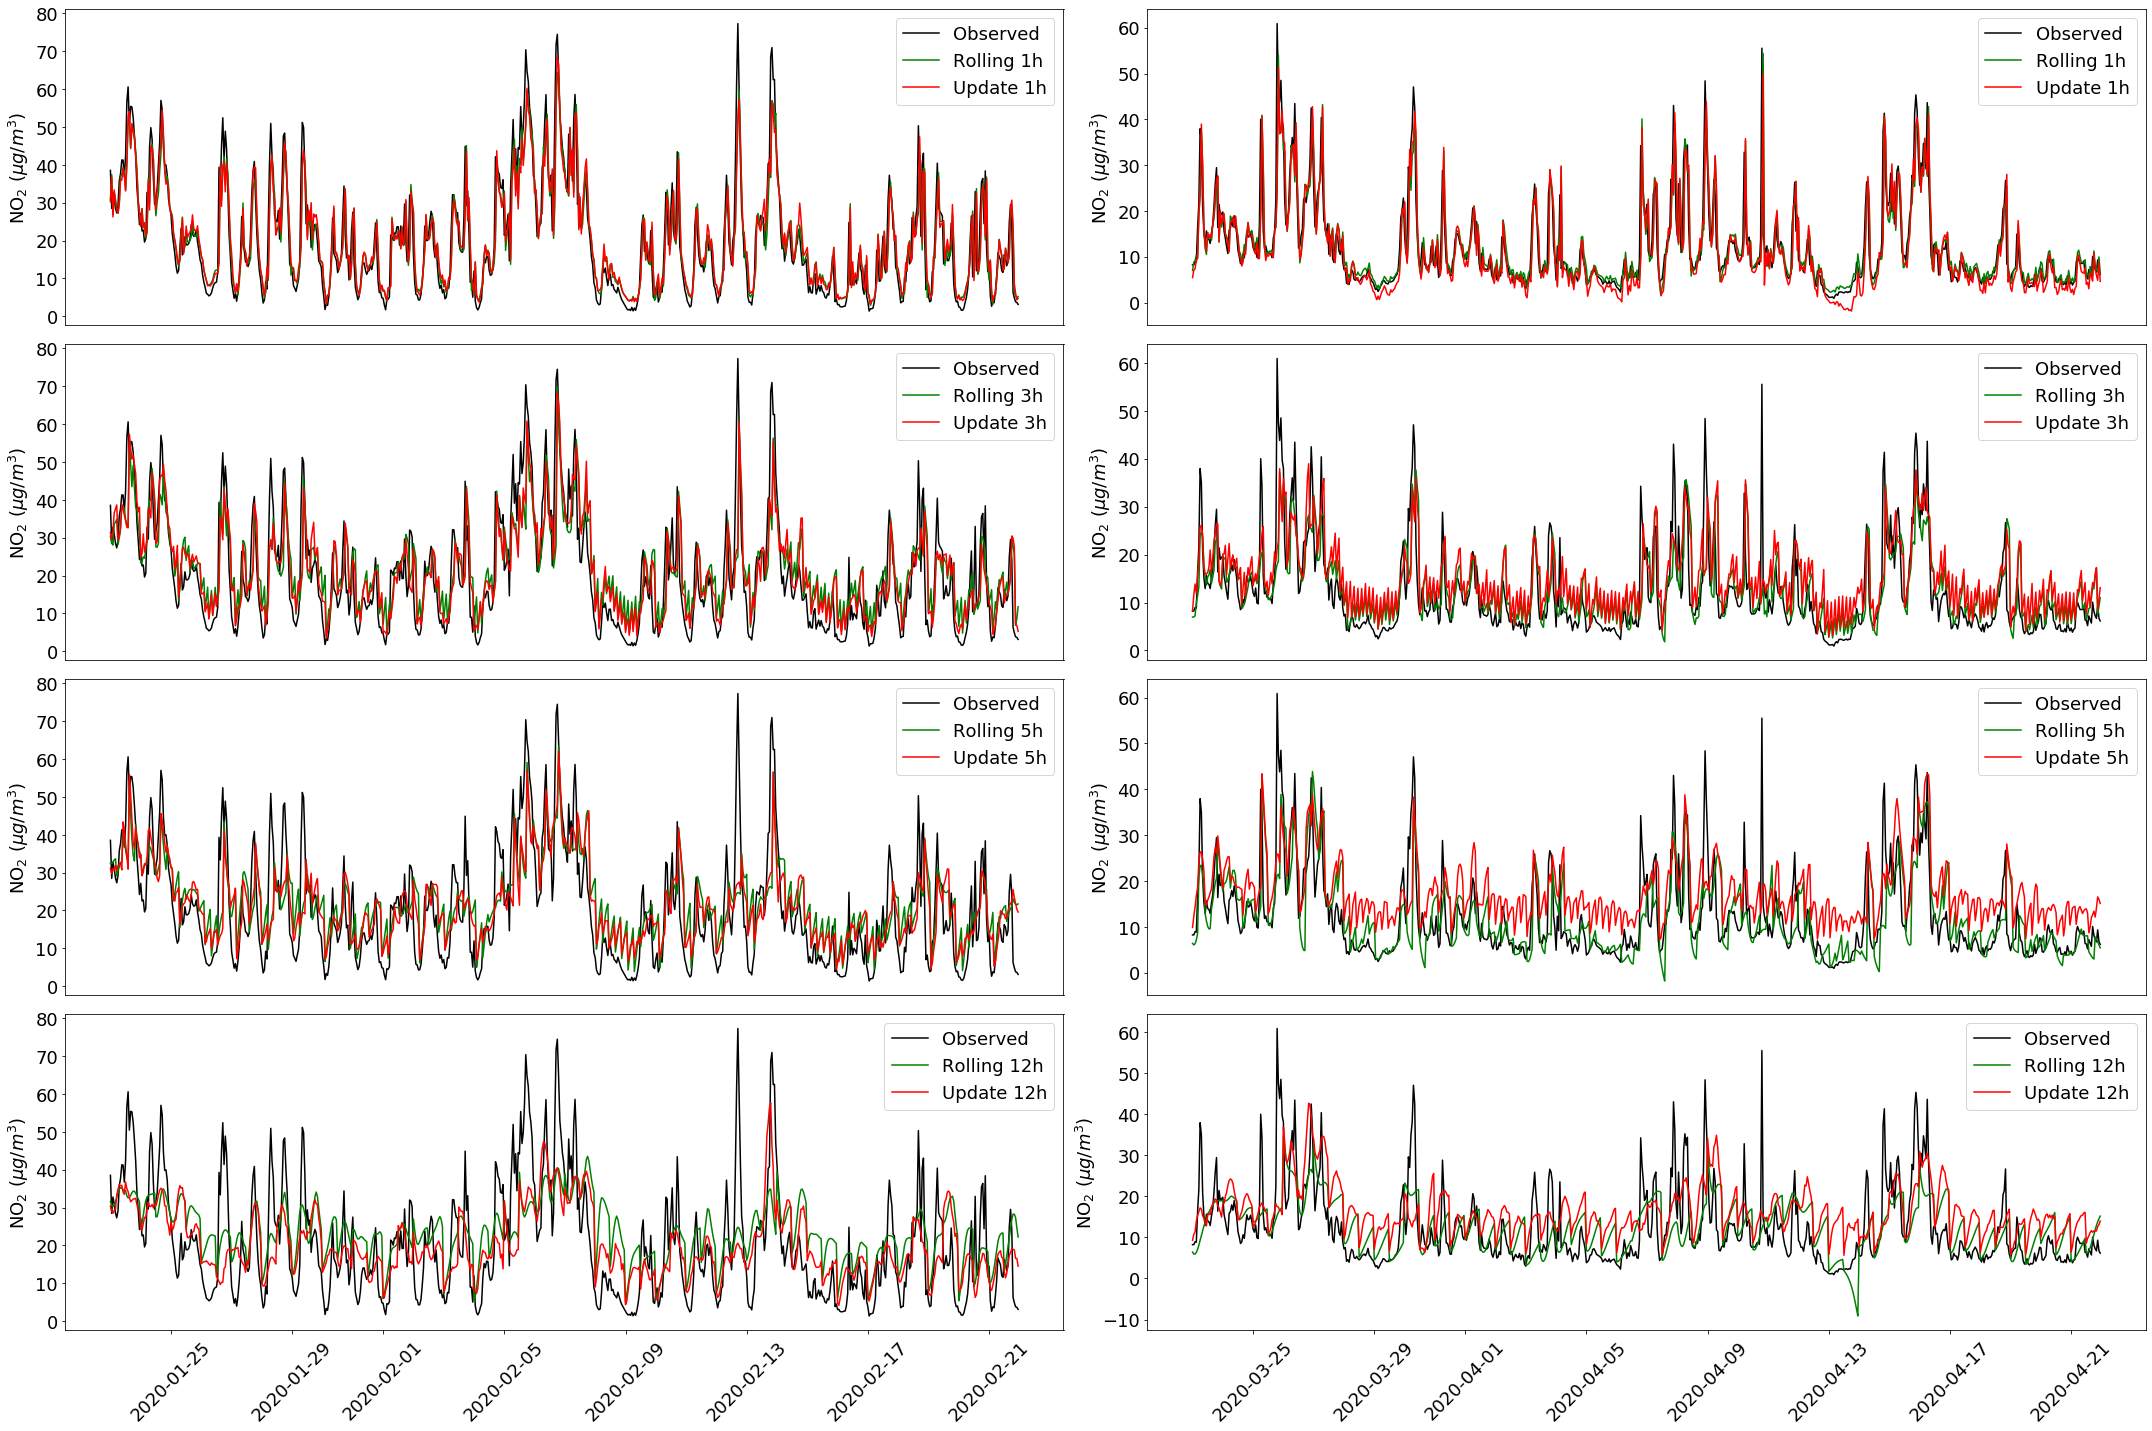

In [40]:
plt.figure(figsize=(30,20))
plt.subplot(4,2,1)
plt.plot(s_dates_nld[:24*30],s_observed_rescaled_nld[:24*30],color='k',label='Observed')
plt.plot(s_datesr_nld[:24*30],s_predicted_rescaledr_nld[:24*30],color='green',label='Rolling 1h')
plt.plot(s_dates_nld[:24*30],s_predicted_rescaled_nld[:24*30],color='r',label='Update 1h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})

plt.subplot(4,2,2)
plt.plot(s_dates[:24*30],s_observed_rescaled[:24*30],color='k',label='Observed')
plt.plot(s_datesr[:24*30],s_predicted_rescaledr[:24*30],color='green',label='Rolling 1h')
plt.plot(s_dates[:24*30],s_predicted_rescaled[:24*30],color='r',label='Update 1h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,3)
plt.plot(s_dates_nld[:24*30],s_observed_rescaled_nld[:24*30],color='k',label='Observed')
plt.plot(s_datesr_nld[:24*30],s_predicted_rescaledr3_nld[:24*30],color='green',label='Rolling 3h')
plt.plot(s_dates_nld[:24*30],s_predicted_rescaled3_nld[:24*30],color='r',label='Update 3h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,4)
plt.plot(s_dates[:24*30],s_observed_rescaled[:24*30],color='k',label='Observed')
plt.plot(s_datesr[:24*30],s_predicted_rescaledr3[:24*30],color='green',label='Rolling 3h')
plt.plot(s_dates[:24*30],s_predicted_rescaled3[:24*30],color='r',label='Update 3h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,5)
plt.plot(s_dates_nld[:24*30],s_observed_rescaled_nld[:24*30],color='k',label='Observed')
plt.plot(s_datesr_nld[:24*30],s_predicted_rescaledr5_nld[:24*30],color='green',label='Rolling 5h')
plt.plot(s_dates_nld[:24*30],s_predicted_rescaled5_nld[:24*30],color='r',label='Update 5h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,6)
plt.plot(s_dates[:24*30],s_observed_rescaled[:24*30],color='k',label='Observed')
plt.plot(s_datesr[:24*30],s_predicted_rescaledr5[:24*30],color='green',label='Rolling 5h')
plt.plot(s_dates[:24*30],s_predicted_rescaled5[:24*30],color='r',label='Update 5h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,7)
plt.plot(s_dates_nld[:24*30],s_observed_rescaled_nld[:24*30],color='k',label='Observed')
plt.plot(s_datesr_nld[:24*30],s_predicted_rescaledr12_nld[:24*30],color='green',label='Rolling 12h')
plt.plot(s_dates_nld[:24*30],s_predicted_rescaled12_nld[:24*30],color='r',label='Update 12h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.xticks(rotation=45)
plt.legend(prop={'size':legendsize})
plt.subplot(4,2,8)
plt.plot(s_dates[:24*30],s_observed_rescaled[:24*30],color='k',label='Observed')
plt.plot(s_datesr[:24*30],s_predicted_rescaledr12[:24*30],color='green',label='Rolling 12h')
plt.plot(s_dates[:24*30],s_predicted_rescaled12[:24*30],color='r',label='Update 12h')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.xticks(rotation=45)
plt.legend(prop={'size':legendsize})
plt.tight_layout()
plt.savefig('./figures/sharston_ext_forecast.png')